# Table of Contents
### 1.Preprocessing of KDD dataset
### 2.PCA
### 3.Pearson correlation
### 4.Variance inflation factor
### 5.Eigenvalues & Condition Index
### 6.Homogeneity Score
### 7.Balance check
### 8.Error analysis
### 9.Decision tree for error analysis
### 10. PDP & ACE & ALE
### 11.Adversarial Attack
### 12.Sensitivity Analysis
### 13.H-case Analysis
__________________________________

## imports

In [1]:
!pip install psynlig
!pip install scikit-plot
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from scikitplot.helpers import binary_ks_curve
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import recall_score, precision_score, f1_score, cohen_kappa_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import fbeta_score, matthews_corrcoef, average_precision_score
from sklearn.metrics import log_loss, brier_score_loss, top_k_accuracy_score
from sklearn.metrics import brier_score_loss, jaccard_score
from sklearn.decomposition import PCA
from psynlig import pca_residual_variance
from imblearn.over_sampling import SMOTE 
from sklearn.tree import DecisionTreeClassifier
from tabulate import tabulate
from sklearn.tree import export_graphviz
from scipy.stats import pearsonr
import graphviz
from sklearn import preprocessing
import statistics
import pickle
import warnings
warnings.filterwarnings('ignore')


[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Data Adjustments on your data

In [ ]:
#import data
df = pd.read_csv(r"./your data",index_col=0).reset_index(drop=True)
pickle_in = open("model.pickle","rb")
#pickle_in is used for Sensitivity Analysis

#Reduce number of data
df = df.sample(n = 40000, random_state=31).reset_index(drop=True)
df_eigen = df_numeric.sample(n = 4000, random_state=31).reset_index(drop=True)
#df_eigen is used for Eigenvalues

#Numerical data
df_numeric = df._get_numeric_data()
column_list = df_numeric.columns.tolist()
#df_numeric is used for Eigenvalues & Condition Index, VIF

#Data frame without TARGET column
feat_df = df.drop(['target'], axis=1)
label_df = df.target
df1 = feat_df._get_numeric_data()
column_list = df1.columns.tolist()

#Data standardization
df_normalized = pd.DataFrame(preprocessing.scale(df1), columns = column_list)

#Median and mean
df_median = np.array(pd.DataFrame(df_normalized).median()).reshape(len(column_list),-1)
df_mean = np.array(pd.DataFrame(df_normalized).mean()).reshape(len(column_list),-1)

# convert categorical features to binary
obj_df = feat_df.select_dtypes(include=['object']).copy()
categorical_df = pd.DataFrame()
for c in range(len(obj_df.columns)) :
    col = obj_df.columns[c]
    cat_df = pd.get_dummies(feat_df[col]).reset_index(drop=True) 
    cat_df = cat_df.iloc[:, :-1]
    categorical_df = pd.concat([categorical_df, cat_df], axis=1)    
features_df = feat_df.drop(obj_df.columns, axis=1)
features_df = pd.concat([features_df, categorical_df], axis=1) 
col_name = features_df.columns
df2 = features_df.copy()
del categorical_df , obj_df

#df2 is used for Pearson correlation, Homogeneity Score

### normalizing
features_df = pd.DataFrame(scale(features_df))
features_df.columns = col_name
x_train, x_test, y_train, y_test = train_test_split(features_df, label_df, train_size = 0.7, random_state = 42)  
train_df = pd.concat([x_train, y_train], axis=1).reset_index(drop = True) 
test_df = pd.concat([x_test, y_test], axis=1).reset_index(drop = True)

## Data Adjustments

## preprocessing of KDD dataset

In [2]:
df = pd.read_csv(r"./kddcup99.csv",index_col=0).reset_index(drop=True)
df = df.sample(n = 40000, random_state=31).reset_index(drop=True)
np.random.seed(42)
# change of decision variable classes by tagging 0 for normal and 1 for fraud ----just for kdd----
df.loc[(df.label !="normal"),"target"] = 1
df.loc[(df.label =="normal"),"target"] = 0
df = df.drop(['label'], axis=1)
feat_df = df.drop(['target'], axis=1)
label_df = df.target

df1 = feat_df._get_numeric_data()
column_list = df1.columns.tolist()
df_numeric = df._get_numeric_data()
df_normalized = pd.DataFrame(preprocessing.scale(df1), columns = column_list)
df_median = np.array(pd.DataFrame(df_normalized).median()).reshape(len(column_list),-1)
df_mean = np.array(pd.DataFrame(df_normalized).mean()).reshape(len(column_list),-1)

# convert categorical features to binary
obj_df = feat_df.select_dtypes(include=['object']).copy()
categorical_df = pd.DataFrame()
for c in range(len(obj_df.columns)) :
    col = obj_df.columns[c]
    cat_df = pd.get_dummies(feat_df[col]).reset_index(drop=True) 
    cat_df = cat_df.iloc[:, :-1]
    categorical_df = pd.concat([categorical_df, cat_df], axis=1)    
features_df = feat_df.drop(obj_df.columns, axis=1)
features_df = pd.concat([features_df, categorical_df], axis=1) 
col_name = features_df.columns
df2 = features_df.copy()  
del categorical_df , obj_df
### normalizing
features_df = pd.DataFrame(scale(features_df))
features_df.columns = col_name
x_train, x_test, y_train, y_test = train_test_split(features_df, label_df, train_size = 0.7, random_state = 42)  
train_df = pd.concat([x_train, y_train], axis=1).reset_index(drop = True) 
test_df = pd.concat([x_test, y_test], axis=1).reset_index(drop = True)

## Residual variance -> Dimensionality Reduction with Principal Component Analysis

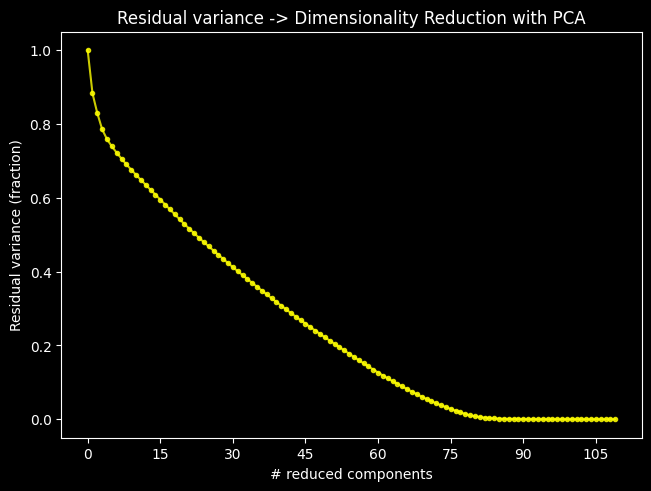

In [3]:
plt.style.use('dark_background')
pca = PCA()
pca.fit_transform(x_train)
pca_residual_variance(pca, marker='o', markersize=3, color = "yellow", alpha=0.8)
plt.xlabel("# reduced components")
plt.title("Residual variance -> Dimensionality Reduction with PCA")
plt.show()
plt.clf()

## Pearson correlation

Features that have Pearson correlation > 0.8

In [4]:
def pearson_correlation():
    for i in range(len(df2.columns)):
        for j in range (i+1,len(df2.columns)):
            crr1 = df2[df2.columns[i]].tolist()
            crr2 = df2[df2.columns[j]].tolist()
            corr, _ = pearsonr(crr1, crr2)
            corr = abs(corr)
            if corr>=0.8:
                yield df2.columns[i]
                yield df2.columns[j]
                yield corr
                
high_correlation = []
for x in pearson_correlation():
    high_correlation.append(x)
feature_1 = []
feature_2 = []
correlation_coefficient = []
for i in range(int(len(high_correlation)/3)):
    feature_1.append(high_correlation[i*3])
    feature_2.append(high_correlation[i*3+1])
    correlation_coefficient.append(high_correlation[i*3+2])
prs_corr = pd.DataFrame({'feature 1' : feature_1 , 'feature 2' : feature_2 ,
                         'pearson correlation coefficient' : correlation_coefficient})
prs_corr = prs_corr.sort_values(by=['pearson correlation coefficient'], ascending=False)
print("\n")
print("---------------------------------------- Pearson correlation ----------------------------------------")
print(tabulate(prs_corr, headers = 'keys', tablefmt = 'psql'))



---------------------------------------- Pearson correlation ----------------------------------------
+----+-----------------------------+-----------------------------+-----------------------------------+
|    | feature 1                   | feature 2                   |   pearson correlation coefficient |
|----+-----------------------------+-----------------------------+-----------------------------------|
| 22 | srv_serror_rate             | dst_host_srv_serror_rate    |                          0.999578 |
| 16 | serror_rate                 | dst_host_serror_rate        |                          0.999025 |
| 23 | srv_serror_rate             | S0                          |                          0.998764 |
| 53 | dst_host_srv_serror_rate    | S0                          |                          0.998549 |
| 50 | dst_host_serror_rate        | dst_host_srv_serror_rate    |                          0.998239 |
| 13 | serror_rate                 | srv_serror_rate             |      

## Variance inflation factor (VIF)

In [5]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

#gather features
features = "+".join(column_list)
# get y and X dataframes based on this regression:
y, X = dmatrices('target ~' + features, df_numeric, return_type='dataframe')
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif[['features','VIF Factor']].dropna()
print(tabulate(vif.round(1), headers = 'keys', tablefmt = 'psql'))

+----+-----------------------------+--------------+
|    | features                    |   VIF Factor |
|----+-----------------------------+--------------|
|  0 | Intercept                   |        243.5 |
|  1 | src_bytes                   |          1.1 |
|  2 | dst_bytes                   |          1   |
|  4 | wrong_fragment              |          1.2 |
|  6 | hot                         |          4.3 |
|  7 | num_failed_logins           |          1   |
|  8 | logged_in                   |          5.2 |
|  9 | lnum_compromised            |          1.2 |
| 10 | lroot_shell                 |          1   |
| 12 | lnum_root                   |          1   |
| 13 | lnum_file_creations         |          1   |
| 15 | lnum_access_files           |          1   |
| 18 | is_guest_login              |          4.3 |
| 19 | count                       |         42.7 |
| 20 | srv_count                   |         96   |
| 21 | serror_rate                 |        849.7 |
| 22 | srv_s

## Eigenvalues & Condition Index

In [23]:
import patsy 
eigen_vals_list = []
for i in range (len(column_list)): 
    x = np.asarray(patsy.dmatrix(f"{column_list[i]} + C(target)", data = df_eigen))
    _, sing_as, _ = np.linalg.svd(x)
    sing_as = sing_as.tolist()
    eigen_vals_list.append(sing_as)
eigen_vals_list = np.array(eigen_vals_list)

In [24]:
eigen_vals_columns = [ '0' , '1' , '2']
eigen_vals_index = column_list
eigen_vals = pd.DataFrame(data = eigen_vals_list , index = eigen_vals_index , columns = eigen_vals_columns)
print("------------------------------EigenValues------------------------------")
print(tabulate(eigen_vals, headers = 'keys', tablefmt = 'psql'))

------------------------------EigenValues------------------------------
+-----------------------------+------------------+---------+-----------+
|                             |                0 |       1 |         2 |
|-----------------------------+------------------+---------+-----------|
| src_bytes                   |      5.14049e+06 | 82.6485 | 19.278    |
| dst_bytes                   | 759578           | 82.6012 | 19.0579   |
| land                        |     82.6822      | 19.2783 |  0        |
| wrong_fragment              |     82.684       | 19.279  |  9.57444  |
| urgent                      |     82.6822      | 19.2783 |  0        |
| hot                         |     82.7386      | 50.5042 | 19.2781   |
| num_failed_logins           |     82.6822      | 19.2783 |  0.999844 |
| logged_in                   |     82.9082      | 29.4463 |  9.0076   |
| lnum_compromised            |     82.6831      | 19.2785 |  4.67419  |
| lroot_shell                 |     82.6822      | 1

In [25]:
import math
condition_index = eigen_vals
for i in eigen_vals_columns:
    max_eigen = eigen_vals[i].max()
    condition_index[i] = (max_eigen/eigen_vals[i])**(1/2)
print("-------------------------Condition Index-------------------------")
print(tabulate(condition_index, headers = 'keys', tablefmt = 'psql'))

-----------------------Condition Index-----------------------
+-----------------------------+-----------+---------+-----------+
|                             |         0 |       1 |         2 |
|-----------------------------+-----------+---------+-----------|
| src_bytes                   |   1       | 1       |   1       |
| dst_bytes                   |   2.60145 | 1.00029 |   1.00576 |
| land                        | 249.342   | 2.07054 | inf       |
| wrong_fragment              | 249.34    | 2.0705  |   1.41898 |
| urgent                      | 249.342   | 2.07054 | inf       |
| hot                         | 249.257   | 1.27925 |   1       |
| num_failed_logins           | 249.342   | 2.07054 |   4.39103 |
| logged_in                   | 249.002   | 1.67534 |   1.46294 |
| lnum_compromised            | 249.341   | 2.07053 |   2.03086 |
| lroot_shell                 | 249.342   | 2.07054 | inf       |
| lsu_attempted               | 249.342   | 2.07054 | inf       |
| lnum_root   

## Homogeneity Score

Features that have Homogeneity Score > 0.9

In [26]:
from sklearn.metrics.cluster import homogeneity_score
from tabulate import tabulate
def homogeneity():
    for i in range(len(df2.columns)):
        for j in range (i+1,len(df2.columns)):
            crr1 = df2[df2.columns[i]].tolist()
            crr2 = df2[df2.columns[j]].tolist()
            corr = homogeneity_score(crr1, crr2)
            corr = abs(corr)
            if corr>=0.9:
                yield df2.columns[i]
                yield df2.columns[j]
                yield corr
                
high_correlation = []
for x in homogeneity():
    high_correlation.append(x)
feature_1 = []
feature_2 = []
correlation_coefficient = []
for i in range(int(len(high_correlation)/3)):
    feature_1.append(high_correlation[i*3])
    feature_2.append(high_correlation[i*3+1])
    correlation_coefficient.append(high_correlation[i*3+2])
homogeneity_corr = pd.DataFrame({'feature 1' : feature_1 , 'feature 2' : feature_2 ,
                         'homogeneity correlation coefficient' : correlation_coefficient})
homogeneity_corr = homogeneity_corr.sort_values(by=['homogeneity correlation coefficient'], ascending=False).reset_index(drop=True)
print("\n")
print("---------------------------------------- Homogeneity Correlation ----------------------------------------")
print(tabulate(homogeneity_corr, headers = 'keys', tablefmt = 'psql'))



---------------------------------------- Homogeneity Correlation ----------------------------------------
+-----+--------------------+-----------------------------+---------------------------------------+
|     | feature 1          | feature 2                   |   homogeneity correlation coefficient |
|-----+--------------------+-----------------------------+---------------------------------------|
|   0 | land               | wrong_fragment              |                              1        |
|   1 | lnum_outbound_cmds | count                       |                              1        |
|   2 | lnum_shells        | time                        |                              1        |
|   3 | lnum_shells        | urh_i                       |                              1        |
|   4 | lnum_shells        | urp_i                       |                              1        |
|   5 | lnum_shells        | uucp                        |                              1        |
|

## Balance check

<Figure size 640x480 with 0 Axes>

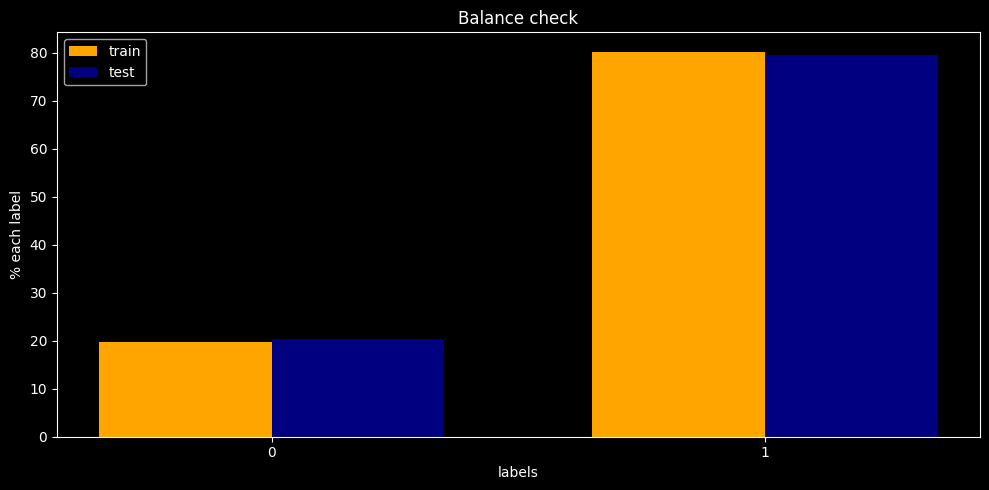



+----+---------+---------+
|    |   train |    test |
|----+---------+---------|
|  0 | 19.7214 | 20.3917 |
|  1 | 80.2786 | 79.6083 |
+----+---------+---------+


In [6]:
train_frauds = (sum(train_df.target)/len(train_df))*100
train_norms = 100 - train_frauds
test_frauds = (sum(test_df.target)/len(test_df))*100
test_norms = 100 - test_frauds
train_per = (train_norms, train_frauds)
test_per = (test_norms, test_frauds)
fig, ax = plt.subplots(figsize = (10, 5))
index = np.arange(2)
bar_width = 0.35
rects1 = plt.bar(index, train_per, bar_width, color='orange', label='train')
rects2 = plt.bar(index + bar_width, test_per, bar_width, color='navy',label='test')
plt.xlabel('labels')
plt.ylabel('% each label')
plt.title('Balance check')
plt.xticks(index + 0.5*bar_width, ('0', '1'))
plt.legend()
plt.tight_layout()
plt.show()
tr_ts_df = pd.DataFrame({'train' : train_per, 'test' : test_per})
print("\n")
print(tabulate(tr_ts_df, headers = 'keys', tablefmt = 'psql'))

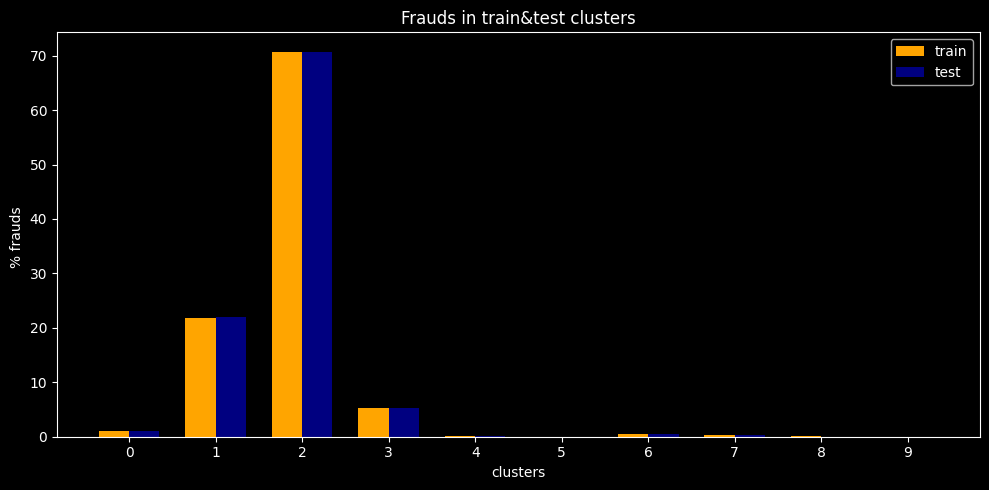

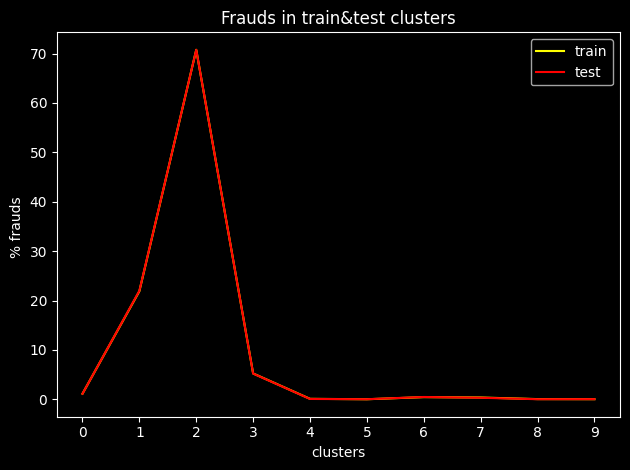



+----+------------------+----------------+
|    |   % train_frauds |   %test_frauds |
|----+------------------+----------------|
|  0 |        1.13444   |      1.13053   |
|  1 |       21.8881    |     21.9722    |
|  2 |       70.7536    |     70.7526    |
|  3 |        5.23178   |      5.21302   |
|  4 |        0.0978735 |      0.0732754 |
|  5 |        0.0133464 |      0.0209358 |
|  6 |        0.444879  |      0.471056  |
|  7 |        0.364801  |      0.314037  |
|  8 |        0.0444879 |      0.0209358 |
|  9 |        0.0266928 |      0.0314037 |
+----+------------------+----------------+


In [7]:
x_all = pd.concat([x_train, x_test], axis=0).reset_index(drop = True)
cluster = 10
data = np.array(x_all).reshape(-1, x_all.shape[1])
km = KMeans(n_clusters = 10, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
x_all['cluster_group'] = km.fit_predict(data).tolist()
train_df['cluster_group'] = x_all['cluster_group'][:len(x_train)].reset_index(drop = True)
test_df['cluster_group'] = x_all['cluster_group'][len(x_train):].reset_index(drop = True)
train_fraud = []
test_fraud = []
for i in range(cluster):
    df_1 = train_df[train_df['cluster_group']==i]
    train_fraud.append(100*sum(df_1.target)/sum(train_df.target))
for i in range(cluster):
    df_1 = test_df[test_df['cluster_group']==i]
    test_fraud.append(100*sum(df_1.target)/sum(test_df.target))
fig, ax = plt.subplots(figsize = (10, 5))
index = np.arange(10)
bar_width = 0.35
rects1 = plt.bar(index, train_fraud, bar_width, color='orange', label='train')
rects2 = plt.bar(index + bar_width, test_fraud, bar_width, color='navy',label='test')
plt.xlabel('clusters')
plt.ylabel('% frauds ')
plt.title('Frauds in train&test clusters')
plt.xticks(index + 0.5*bar_width, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
plt.legend()
plt.tight_layout()
plt.show()
plt.clf()
print("\n")
plt.plot(index, train_fraud, color = "yellow", label='train')
plt.plot(index, test_fraud, color = "red", label='test')
plt.xlabel('clusters')
plt.ylabel('% frauds ')
plt.title('Frauds in train&test clusters')
plt.xticks(index , ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
plt.legend()
plt.tight_layout()
plt.show()

tr_ts_df2 = pd.DataFrame({'% train_frauds' : train_fraud, '%test_frauds' : test_fraud})
print("\n")
print(tabulate(tr_ts_df2, headers = 'keys', tablefmt = 'psql'))

## Error analysis

unsupervised anomaly detection model : One-Class Support Vector Machines

### train step

In [8]:
# confusion matrix
np.random.seed(31)
svm_model = svm.OneClassSVM()
svm_model.fit(x_train)
svm_pred = svm_model.predict(x_train)
svm_pred = pd.Series(svm_pred).replace([-1,1],[1,0])
svm_conf_mat = pd.DataFrame(confusion_matrix(y_train, svm_pred))

In [9]:
index = []
test_score = [] 
tn, fp, fn, tp = confusion_matrix(y_train, svm_pred).ravel()
index.append("accuracy")
test_score.append((tp + tn) / (tp + fp + fn + tn))
index.append("recall_score")
test_score.append(recall_score(y_train, svm_pred)) 
index.append("precision_score")
test_score.append(precision_score(y_train, svm_pred))
index.append("f1_score")
test_score.append(f1_score(y_train, svm_pred)) 
index.append("f2_score")
test_score.append(fbeta_score(y_train, svm_pred, beta = 2))
index.append("cohen_kappa_score")
test_score.append(cohen_kappa_score(y_train, svm_pred))
index.append("roc_auccuracy_score")
test_score.append(roc_auc_score(y_train, svm_pred))
index.append("false_positive_rate")
test_score.append(fp / (fp + tn))
index.append("false_negative_rate")
test_score.append(fn / (tp + fn))
index.append("true_negative_rate")
test_score.append(tn / (tn + fp))
index.append("negative_predictive_value")
test_score.append(tn/ (tn + fn))
index.append("false_discovery_rate")
test_score.append(fp/ (tp + fp))
index.append("matthews_corr")
test_score.append(matthews_corrcoef(y_train, svm_pred))
index.append("avg_precision")
test_score.append(average_precision_score(y_train, svm_pred))
index.append("log_loss")
test_score.append(log_loss(y_train, svm_pred))
index.append("brier_score_loss")
test_score.append(brier_score_loss(y_train, svm_pred))
index.append("binary_ks_curve")
res = binary_ks_curve(y_train, svm_pred)
test_score.append(res[3])
from sklearn.metrics import balanced_accuracy_score
index.append("balanced_accuracy_score")
test_score.append(balanced_accuracy_score(y_train, svm_pred))
index.append("top_k_accuracy_score")
test_score.append(top_k_accuracy_score(y_train, svm_pred, k=2))
index.append("brier_score_loss")
test_score.append(brier_score_loss(y_train, svm_pred))
index.append("jaccard_score")
test_score.append(jaccard_score(y_train, svm_pred))
score_df1 = pd.DataFrame({"index":index ,"score" :test_score })
y_df_train = pd.DataFrame(y_train).reset_index(drop = True)
y_df_train['pred_label'] = svm_pred
clusters = train_df.cluster_group.reset_index()
y_df_train['cluster_group'] = clusters.cluster_group
per_error_train = []
for j in range(cluster):
    df = y_df_train[y_df_train.cluster_group == j]
    fr_df = df[df.target == 1]
    real = max(len(fr_df.target) , 1)
    err = len(fr_df[fr_df.pred_label == 0])
    per_error_train.append(100*err/real)

### test step

In [10]:
# confusion matrix
svm_pred_test = svm_model.predict(x_test)
svm_pred_test = pd.Series(svm_pred_test).replace([-1,1],[1,0])
svm_conf_mat_test = pd.DataFrame(confusion_matrix(y_test, svm_pred_test))

In [11]:
index = []
test_score = [] 
tn, fp, fn, tp = confusion_matrix(y_test, svm_pred_test).ravel()
index.append("accuracy")
test_score.append((tp + tn) / (tp + fp + fn + tn))
index.append("recall_score")
test_score.append(recall_score(y_test, svm_pred_test)) 
index.append("precision_score")
test_score.append(precision_score(y_test, svm_pred_test))
index.append("f1_score")
test_score.append(f1_score(y_test, svm_pred_test)) 
index.append("f2_score")
test_score.append(fbeta_score(y_test, svm_pred_test, beta = 2))
index.append("cohen_kappa_score")
test_score.append(cohen_kappa_score(y_test, svm_pred_test))
index.append("roc_auccuracy_score")
test_score.append(roc_auc_score(y_test, svm_pred_test))
index.append("false_positive_rate")
test_score.append(fp / (fp + tn))
index.append("false_negative_rate")
test_score.append(fn / (tp + fn))
index.append("true_negative_rate")
test_score.append(tn / (tn + fp))
index.append("negative_predictive_value")
test_score.append(tn/ (tn + fn))
index.append("false_discovery_rate")
test_score.append(fp/ (tp + fp))
index.append("matthews_corr")
test_score.append(matthews_corrcoef(y_test, svm_pred_test))
index.append("avg_precision")
test_score.append(average_precision_score(y_test, svm_pred_test))
index.append("log_loss")
test_score.append(log_loss(y_test, svm_pred_test))
index.append("brier_score_loss")
test_score.append(brier_score_loss(y_test, svm_pred_test))
index.append("binary_ks_curve")
res = binary_ks_curve(y_test, svm_pred_test)
test_score.append(res[3])
from sklearn.metrics import balanced_accuracy_score
index.append("balanced_accuracy_score")
test_score.append(balanced_accuracy_score(y_test, svm_pred_test))
index.append("top_k_accuracy_score")
test_score.append(top_k_accuracy_score(y_test, svm_pred_test, k=2))
index.append("brier_score_loss")
test_score.append(brier_score_loss(y_test, svm_pred_test))
index.append("jaccard_score")
test_score.append(jaccard_score(y_test, svm_pred_test))
score_df2 = pd.DataFrame({"index":index ,"score" :test_score })
y_df_test = pd.DataFrame(y_test).reset_index(drop = True)
y_df_test['pred_label'] = svm_pred_test
clusters = test_df.cluster_group.reset_index()
y_df_test['cluster_group'] = clusters.cluster_group
per_error_tset = []
for j in range(cluster):
    df = y_df_test[y_df_test.cluster_group == j]
    fr_df = df[df.target == 1]
    real = max(len(fr_df.target) , 1)
    err = len(fr_df[fr_df.pred_label == 0])
    per_error_tset.append(100*err/real)

In [12]:
from IPython.display import display_html 

print('---- confusion matrix ----')
svm_conf_mat_test_1 = svm_conf_mat_test.style.set_table_attributes("style='display:inline; margin-right:20px;'").set_caption("test")
svm_conf_mat_1 = svm_conf_mat.style.set_table_attributes("style='display:inline'").set_caption("train")

display_html(svm_conf_mat_1._repr_html_() + svm_conf_mat_test_1._repr_html_(), raw=True)

---- confusion matrix ----


,0,1
0,790,4732
1,3546,18932
,0,1
0,353,2094
1,1445,8108


In [13]:
### summary scores in dataframe 
print('--------------------------- scores -----------------------------')

score_df_test = score_df2.style.set_table_attributes("style='display:inline; margin-right:20px;'").set_caption("test")
score_df_train = score_df1.style.set_table_attributes("style='display:inline'").set_caption("train")

display_html(score_df_train._repr_html_() + score_df_test._repr_html_(), raw=True)

--------------------------- scores -----------------------------


,index,score
0,accuracy,0.704357
1,recall_score,0.842246
2,precision_score,0.800034
3,f1_score,0.820597
4,f2_score,0.833451
5,cohen_kappa_score,-0.015985
6,roc_auccuracy_score,0.492655
7,false_positive_rate,0.856936
8,false_negative_rate,0.157754
9,true_negative_rate,0.143064


Display "% False Negative /  all_real_fraud" in each *cluster*

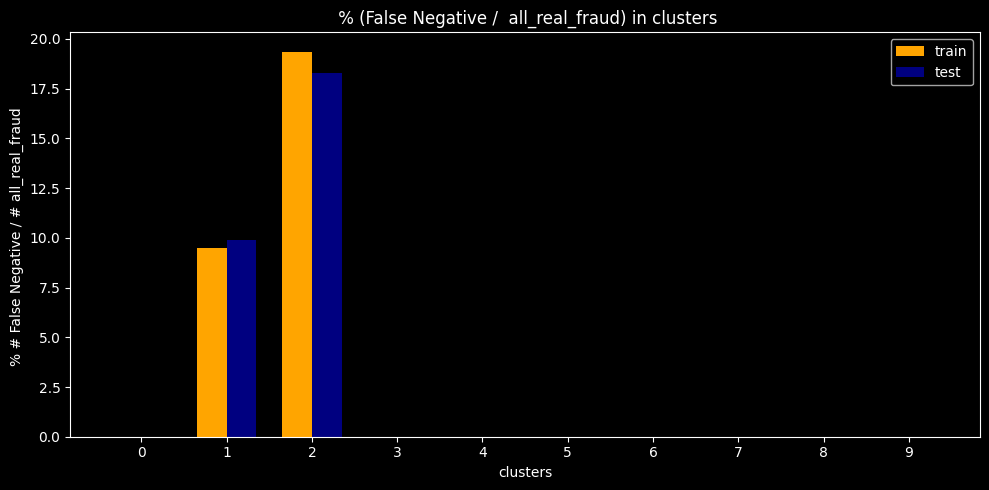



+----+----------+----------+
|    |    train |     test |
|----+----------+----------|
|  0 |  0       |  0       |
|  1 |  9.47154 |  9.90948 |
|  2 | 19.3662  | 18.3015  |
|  3 |  0       |  0       |
|  4 |  0       |  0       |
|  5 |  0       |  0       |
|  6 |  0       |  0       |
|  7 |  0       |  0       |
|  8 |  0       |  0       |
|  9 |  0       |  0       |
+----+----------+----------+


In [14]:
fig, ax = plt.subplots(figsize = (10, 5))
index = np.arange(10)
bar_width = 0.35
rects1 = plt.bar(index, per_error_train, bar_width, color='orange', label='train')
rects2 = plt.bar(index + bar_width, per_error_tset, bar_width, color='navy',label='test')
plt.xlabel('clusters')
plt.ylabel('% # False Negative / # all_real_fraud ')
plt.title(' % (False Negative /  all_real_fraud) in clusters')
plt.xticks(index + 0.5*bar_width, ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9'))
plt.legend()
plt.tight_layout()
plt.show()
print("\n")
df_fn = pd.DataFrame({'train' : per_error_train, 'test' : per_error_tset})
print(tabulate(df_fn, headers = 'keys', tablefmt = 'psql'))

## Decision tree for error analysis

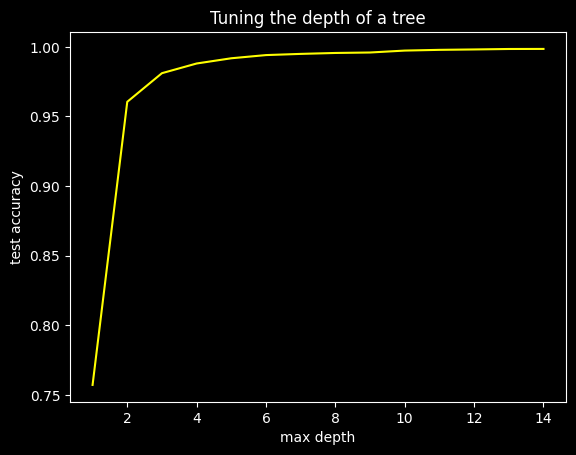



------- Tuned model scores : -------
Training set accuracy: 0.994
Test set accuracy: 0.994
------------------------------------

------------ Feature Importance ------------
+----+------------------------+--------------+
|    | feature                |   importance |
|----+------------------------+--------------|
| 19 | srv_count              |        0.877 |
| 18 | count                  |        0.075 |
| 24 | same_srv_rate          |        0.027 |
| 35 | dst_host_rerror_rate   |        0.008 |
| 29 | dst_host_same_srv_rate |        0.005 |
| 30 | dst_host_diff_srv_rate |        0.004 |
| 52 | ecr_i                  |        0.002 |
| 20 | serror_rate            |        0.002 |
| 63 | iso_tsap               |        0     |
| 82 | printer                |        0     |
| 81 | pop_3                  |        0     |
| 61 | http_443               |        0     |
| 80 | pop_2                  |        0     |
| 79 | pm_dump                |        0     |
| 62 | imap4             

In [15]:
train_df =  pd.concat([x_train.reset_index(drop =True), y_train.reset_index(drop =True)], axis=1)
svm_df_train = pd.DataFrame(svm_pred, columns = ['pred_label']).reset_index(drop =True)
train_df = pd.concat([train_df, svm_df_train], axis=1)
test_df =  pd.concat([x_test.reset_index(drop =True), y_test.reset_index(drop =True)], axis=1)
svm_df_test = pd.DataFrame(svm_pred_test, columns = ['pred_label']).reset_index(drop =True)
test_df = pd.concat([test_df, svm_df_test], axis=1)
new_df = pd.concat([train_df, test_df], axis=0).reset_index(drop =True)
new_df['fn_error'] = None
for r in range(len(new_df)) :
    if ((new_df.target[r] == 1) and (new_df.pred_label[r] == 0)) :
        new_df.fn_error[r] = 1
    else :
        new_df.fn_error[r] = 0
dt_df = new_df.drop(['target', 'pred_label'], axis=1)
### 
x_new = dt_df.drop(['fn_error'], axis=1)
y_new = dt_df.fn_error.astype('int')
sm = SMOTE(random_state=42)
x_blnc, y_blnc = sm.fit_resample(x_new, y_new)
x_train_dt, x_test_dt, y_train_dt, y_test_dt = train_test_split(x_blnc, y_blnc, train_size = 0.7, random_state = 42)
# List of values to try for max_depth:
max_depth_range = list(range(1, 15))
# List to store the accuracy for each value of max_depth:
test_accuracy = []
for depth in max_depth_range:
    
    dt_clf = DecisionTreeClassifier(max_depth = depth, random_state = 0)
    dt_clf.fit(x_train_dt, y_train_dt)
    score = dt_clf.score(x_test_dt, y_test_dt)
    test_accuracy.append(score)

fig = plt.figure()
ax = plt.axes()
plt.plot(max_depth_range, test_accuracy, color = "yellow")
plt.xlabel("max depth")
plt.ylabel("test accuracy")
plt.title("Tuning the depth of a tree")
plt.show()
dt_clf = DecisionTreeClassifier(max_depth = 6, random_state = 0)
dt_clf.fit(x_train_dt, y_train_dt)
print("\n")
print("------- Tuned model scores : -------")
print("Training set accuracy: {:.3f}".format(dt_clf.score(x_train_dt, y_train_dt)))
print("Test set accuracy: {:.3f}".format(dt_clf.score(x_test_dt, y_test_dt)))
print("------------------------------------\n")
print("------------ Feature Importance ------------")
importances = pd.DataFrame({'feature':x_train_dt.columns,'importance':np.round(dt_clf.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False)
print(tabulate(importances.iloc[:15, :], headers = 'keys', tablefmt = 'psql'))


In [ ]:
### show the tree
export_graphviz(dt_clf,out_file="tree.dot")
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [78]:
import sklearn
def tree_to_df(reg_tree, feature_names):
    tree_ = reg_tree.tree_
    feature_name = [
        feature_names[i] if i != sklearn.tree._tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse(node, row, ret):
        if tree_.feature[node] != sklearn.tree._tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            # Add rule to row and search left branch
            row[-1].append(name + " <= " +  str(round(threshold,3)))
            recurse(tree_.children_left[node], row, ret)
            # Add rule to row and search right branch
            row[-1].append(name + " > " +  str(round(threshold,3)))
            recurse(tree_.children_right[node], row, ret)
        else:
            # Add output rules and start a new row
            label = tree_.value[node]
            ret.append("Value: [" + str(label[0][0]) + ',' + str(label[0][1]) + "]")
            row.append([])
    
    # Initialize
    rules = [[]]
    vals = []
    
    # Call recursive function with initial values
    recurse(0, rules, vals)
    
    # Convert to table and output
    df_tree = pd.DataFrame(rules).dropna(how='all')
    df_tree['Return'] = pd.Series(vals)
    columns = []
    for i in range(6):
        columns.append(f"Depth {i}")
    columns.append('Values')
    df_tree.columns = columns
    return df_tree

tree_to_df(dt_clf , df2.columns.tolist())

,Depth 0,Depth 1,Depth 2,Depth 3,Depth 4,Depth 5,Values
0,srv_count <= 0.889,srv_count <= -1.115,srv_count <= -1.119,srv_count <= -1.127,srv_count <= -1.143,dst_host_same_src_port_rate <= 0.819,"Value: [6666.0,1.0]"
1,dst_host_same_src_port_rate > 0.819,None,None,None,None,None,"Value: [424.0,3.0]"
2,srv_count > -1.143,srv_count <= -1.14,None,None,None,None,"Value: [0.0,2.0]"
3,srv_count > -1.14,None,None,None,None,None,"Value: [1670.0,10.0]"
4,srv_count > -1.127,srv_count <= -1.123,None,None,None,None,"Value: [0.0,9.0]"
5,srv_count > -1.123,dst_host_srv_count <= -1.624,None,None,None,None,"Value: [559.0,0.0]"
6,dst_host_srv_count > -1.624,None,None,None,None,None,"Value: [188.0,12.0]"
7,srv_count > -1.119,count <= -0.624,serror_rate <= 0.918,None,None,None,"Value: [104.0,0.0]"
8,serror_rate > 0.918,dst_host_diff_srv_rate <= 0.215,None,None,None,None,"Value: [1.0,94.0]"
9,dst_host_diff_srv_rate > 0.215,None,None,None,None,None,"Value: [75.0,37.0]"


### PDP
Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the ‘complement’ features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.

In [47]:
features = importances.feature[:2].tolist()

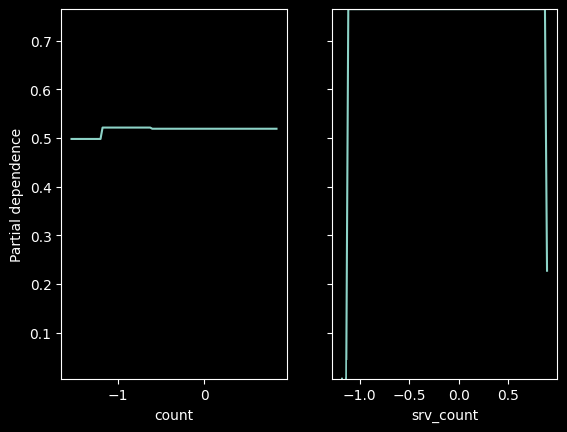

In [48]:
#Partial dependence plots
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(dt_clf,
                                       X = x_train_dt,
                                       features = features, 
                                       target=0)
plt.gcf()

### ICE
Similar to a PDP, an individual conditional expectation (ICE) plot shows the dependence between the target function and an input feature of interest. However, unlike a PDP, which shows the average effect of the input feature, an ICE plot visualizes the dependence of the prediction on a feature for each sample separately with one line per sample.

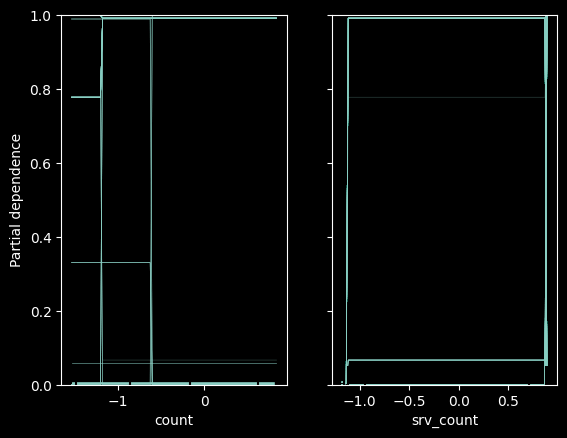

In [49]:
#Individual conditional expectation
PartialDependenceDisplay.from_estimator(dt_clf, x_train_dt, features ,kind='individual')
plt.gcf()

### ALE
Accumulated local effects describe how features influence the prediction of a machine learning model on average. ALE plots are a faster and unbiased alternative to partial dependence plots (PDPs).

PyALE._ALE_generic:INFO: Continuous feature detected.


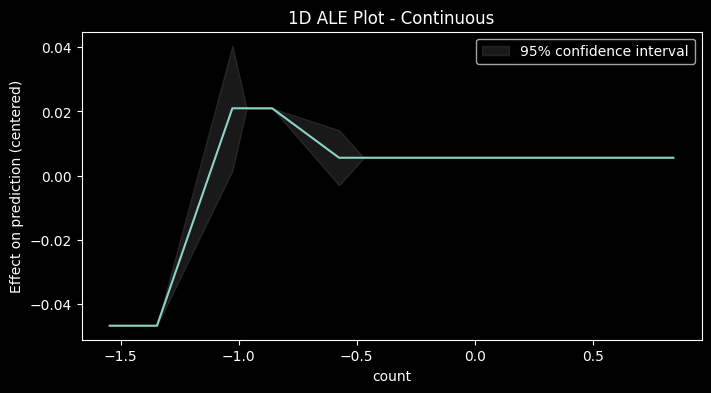

In [53]:
from PyALE import ale
ale_eff = ale(X=x_train_dt, model=dt_clf, feature=[features[0]], grid_size=50, include_CI=True, C=0.95)
plt.gcf()

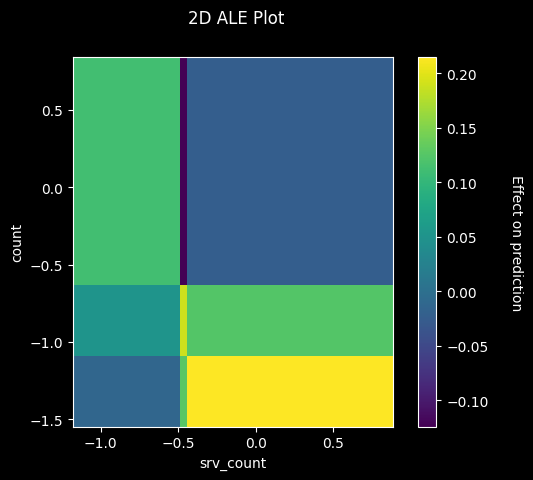

In [55]:
ale_eff2D = ale(X=x_train_dt, model=dt_clf, feature=features, grid_size=100)
plt.gcf()

### Permutation feature importance
Permutation feature importance is a model inspection technique that can be used for any fitted estimator when the data is tabular. This is especially useful for non-linear or opaque estimators. The permutation feature importance is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature. This technique benefits from being model agnostic and can be calculated many times with different permutations of the feature.

In [90]:
from sklearn.inspection import permutation_importance
r = permutation_importance(dt_clf, x_train_dt, y_train_dt,
                           n_repeats=30,
                           random_state=0)
a = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        a.append(i)
        print(f"{col_name[i]:<8}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

srv_count0.395 +/- 0.002
dst_host_diff_srv_rate0.061 +/- 0.001
dst_host_same_srv_rate0.054 +/- 0.001
same_srv_rate0.051 +/- 0.001
count   0.022 +/- 0.000
dst_host_rerror_rate0.018 +/- 0.000
ecr_i   0.014 +/- 0.000
dst_host_srv_count0.003 +/- 0.000
serror_rate0.002 +/- 0.000
diff_srv_rate0.000 +/- 0.000


### Global Surrogate
A global surrogate model is an interpretable model that is trained to approximate the predictions of a black box model. We can draw conclusions about the black box model by interpreting the surrogate model.

In [82]:
from sklearn.tree import DecisionTreeRegressor
new_target = dt_clf.predict(x_train_dt)

# defining the interpretable decision tree model
dt_model1 = DecisionTreeRegressor(max_depth=5, random_state=10)

# fitting the surrogate decision tree model using the training set and new target
dt_model1.fit(x_train_dt,new_target)

DecisionTreeRegressor(max_depth=5, random_state=10)

### Implementing LIME to generate local interpretations

In [94]:
from lime.lime_tabular import LimeTabularExplainer

explainer = LimeTabularExplainer(x_train_dt.values, mode="regression", feature_names=x_train_dt.columns)

# storing a new observation
i = 6
for i in a:
    X_observation = x_test_dt.iloc[[i], :]

    print(f'RF prediction {col_name[i]} : {dt_clf.predict(X_observation)[0]}')

RF prediction srv_count : 1
RF prediction dst_host_diff_srv_rate : 1
RF prediction dst_host_same_srv_rate : 1
RF prediction same_srv_rate : 1
RF prediction count : 1
RF prediction dst_host_rerror_rate : 1
RF prediction ecr_i : 0
RF prediction dst_host_srv_count : 0
RF prediction serror_rate : 1
RF prediction diff_srv_rate : 1


In [95]:
explanation = explainer.explain_instance(X_observation.values[0], dt_clf.predict)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

0.6332831862982782


### Shaply values
It has optimized functions for interpreting tree-based models and a model agnostic explainer function for interpreting any black-box model for which the predictions are known.

In [114]:
from xgboost.sklearn import XGBRegressor
import shap
shap.initjs()

In [110]:
from sklearn.metrics import mean_squared_error
xgb_model = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001, random_state=0)
xgb_model.fit(x_train_dt, y_train_dt)
y_predict = xgb_model.predict(x_test_dt)
mean_squared_error(y_test_dt, y_predict)**(0.5)

0.18885016697888365

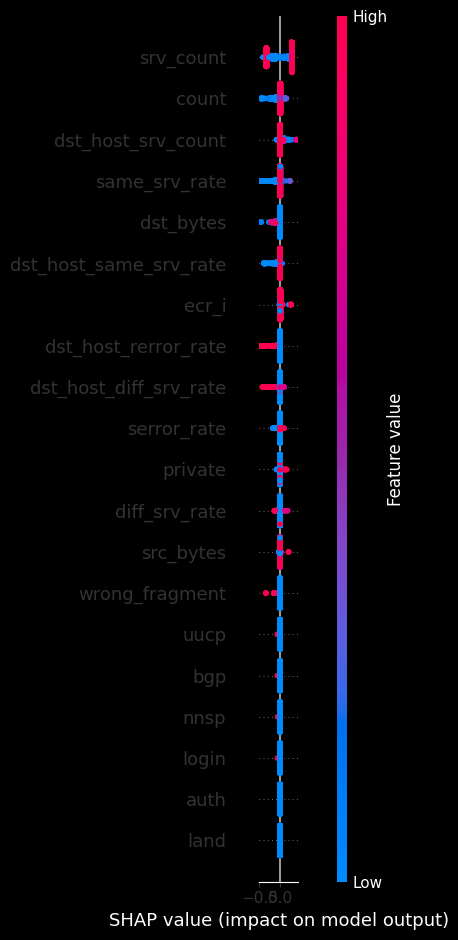

In [118]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(x_train_dt)
shap.summary_plot(shap_values, features=x_train_dt, feature_names=x_train_dt.columns)

## Adversarial Attack

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Import library

In [2]:
import tensorflow.compat.v1 as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import pandas as pd
import numpy as np
from keras.utils import np_utils
from cleverhans.future.tf2.attacks import fast_gradient_method,basic_iterative_method
from sklearn.datasets import fetch_kddcup99

In [13]:
df = pd.read_csv(r"./kddcup99.csv",index_col=0).reset_index(drop=True)
COL_NAME = df.columns.tolist()
COL_NAME.insert(0, "duration")
COL_NAME.remove('label')
df_numeric = df._get_numeric_data()
NUMERIC_COLS = df_numeric.columns.tolist()
NUMERIC_COLS.insert(0, "duration")

def get_ds():
    """ get_ds: Get the numeric values of the KDDCUP'99 dataset. """
    x_kddcup, y_kddcup = fetch_kddcup99(return_X_y=True, shuffle=False)
    df_kddcup = pd.DataFrame(x_kddcup, columns=COL_NAME)
    df_kddcup['label'] = y_kddcup
    df_kddcup.drop_duplicates(keep='first', inplace=True)
    df_kddcup['label'] = df_kddcup['label'].apply(lambda d: \
                                    str(d).replace('.', '').replace("b'", "").\
                                        replace("'", ""))
    

    conversion_dict = {'back':'r2l', 'buffer_overflow':'u2r', 'ftp_write':'r2l',
                       'guess_passwd':'r2l', 'imap':'r2l', 'ipsweep':'r2l',
                       'land':'r2l', 'loadmodule':'u2r', 'multihop':'r2l',
                       'neptune':'r2l', 'nmap':'r2l', 'perl':'u2r', 'phf':'r2l',
                       'pod':'r2l', 'portsweep':'r2l', 'rootkit':'u2r',
                       'satan':'r2l', 'smurf':'r2l', 'spy':'r2l', 'teardrop':'r2l',
                       'warezclient':'r2l', 'warezmaster':'r2l'}
    df_kddcup['label'] = df_kddcup['label'].replace(conversion_dict)
    df_kddcup = df_kddcup.query("label != 'u2r'")
    df_y = pd.DataFrame(df_kddcup.label, columns=["label"], dtype="category")
    df_kddcup.drop(["label"], inplace=True, axis=1)
    x_kddcup = df_kddcup[NUMERIC_COLS].values
    x_kddcup = preprocessing.scale(x_kddcup)
    y_kddcup = df_y.label.cat.codes.to_numpy()
    return x_kddcup, y_kddcup

The tensorflow based classification model is then given for example as exercise here:

In [4]:
def create_tf_model(input_size, num_of_class):
    """ This method creates the tensorflow classification model """
    model_kddcup = tf.keras.Sequential([
        tf.keras.layers.Dense(200, input_dim=input_size, activation=tf.nn.relu),
        tf.keras.layers.Dense(500, activation=tf.nn.relu),
        tf.keras.layers.Dense(200, activation=tf.nn.relu),
        tf.keras.layers.Dense(num_of_class),
        # We seperate the activation layer to be able to access
        # the logits of the previous layer later
        tf.keras.layers.Activation(tf.nn.softmax)
        ])
    model_kddcup.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])
    return model_kddcup

The next step is to create adversarial machine learning attacks using CleverHans library. we used fast-gradient sign method (FGSM) and basic iterative method (BIM) attacks for the Tensorflow library.

In [5]:
def gen_tf2_fgsm_attack(org_model, x_test):
    """ This method creates adversarial examples with fgsm """
    logits_model = tf.keras.Model(org_model.input, model.layers[-1].output)

    epsilon = 0.1
    adv_fgsm_x = fast_gradient_method(logits_model,
                                      x_test,
                                      epsilon,
                                      np.inf,
                                      targeted=False)
    return adv_fgsm_x

def gen_tf2_bim(org_model, x_test):
    """ This method creates adversarial examples with bim """
    logits_model = tf.keras.Model(org_model.input, model.layers[-1].output)

    epsilon = 0.1
    adv_bim_x = basic_iterative_method(logits_model,
                                       x_test,
                                       epsilon,
                                       0.1,
                                       nb_iter=10,
                                       norm=np.inf,
                                       targeted=True)
    return adv_bim_x

Let’s continue with the training of the attack detection model with the normal KDDCUP’99 dataset

#### Original Model’s Confusion Matrix
The original model’s confusion matrix is shown here. According to the confusion matrix, the model’s classification performance quite good.

In [40]:
EPOCH = 50
TEST_RATE = 0.2
VALIDATION_RATE = 0.2

X, y = get_ds()

num_class = len(np.unique(y))

attack_functions = [gen_tf2_bim,
                    gen_tf2_fgsm_attack]

model = create_tf_model(X.shape[1], num_class)

X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                    test_size=TEST_RATE)
y_train_cat = np_utils.to_categorical(y_train)
y_test_cat = np_utils.to_categorical(y_test)

history = model.fit(X_train, y_train_cat, epochs=EPOCH,
                    batch_size=50000, verbose=0,
                    validation_split=VALIDATION_RATE)

y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
cm_org = confusion_matrix(y_test, y_pred)
print("*"*50)
print("Original confusion matrix")
print(cm_org)

910/910 [==============================] - 2s 2ms/step
**************************************************
Original confusion matrix
[[17572    36]
 [   39 11460]]


Let’s continue with the attacks, attacked model’s confusion matrices and adversarial trained model’s confusion matrices

In [41]:
for attack_function in attack_functions:
        print("*"*20)
        print("Attack function is ", attack_function)
        
        model = create_tf_model(X.shape[1], num_class)
        history = model.fit(X_train, y_train_cat, epochs=EPOCH,
                            batch_size=50000, verbose=0,
                            validation_split=VALIDATION_RATE)
        
        X_adv_list = []
        y_adv_list = []

        adv_x = attack_function(model, X_test)
        y_pred = model.predict(adv_x)
        y_pred = np.argmax(y_pred,axis=1)
        cm_adv = confusion_matrix(y_test, y_pred)
        print("*"*20)
        print("Attacked confusion matrix")
        print(cm_adv)

        print("Adversarial training")
        # define the checkpoint

        adv_x = attack_function(model, X_train)
        adv_x_test = attack_function(model, X_test)

        concat_adv_x = np.concatenate([X_train, adv_x])
        concat_y_train = np.concatenate([y_train_cat, y_train_cat])

        history = model.fit(concat_adv_x, concat_y_train, epochs=EPOCH,
                            batch_size=50000, verbose=0,
                            validation_data=(adv_x_test, y_test_cat))

        y_pred = model.predict(adv_x_test)
        y_pred = np.argmax(y_pred,axis=1)
        cm_adv = confusion_matrix(y_test, y_pred)
        print("*"*20)
        print("Attacked confusion matrix - adv training")
        print(cm_adv)

********************
Attack function is  <function gen_tf2_bim at 0x000002425664CE50>
910/910 [==============================] - 2s 2ms/step
********************
Attacked confusion matrix
[[17570    38]
 [   38 11461]]
Adversarial training
910/910 [==============================] - 2s 2ms/step
********************
Attacked confusion matrix - adv training
[[17583    25]
 [   28 11471]]
********************
Attack function is  <function gen_tf2_fgsm_attack at 0x0000024309CCCA60>
910/910 [==============================] - 2s 2ms/step
********************
Attacked confusion matrix
[[17167   441]
 [  318 11181]]
Adversarial training
910/910 [==============================] - 2s 2ms/step
********************
Attacked confusion matrix - adv training
[[17580    28]
 [   22 11477]]


## Sensitivity Analysis 

In [ ]:
model = pickle.load(pickle_in)

In [100]:
interval= 40 #assumed
numbers = [interval*float(x)/10 for x in range(-10 , 11)]

if len(numbers)%2 == 0:
    counter1 = len(numbers)/2
    counter2 = counter1+1
else:
    counter1 = (len(numbers)+1)/2
    counter2 = (len(numbers)-3)/2

In [ ]:
full=[]
for i in range(len(column_list)):
    res=[]
    for j in numbers:
        df[i][0] = j
        res.append(model)
    full.append(res)

In [7]:
full = np.array(full)
full = full.T
prob_data = pd.DataFrame(full , columns = column_list)
prob_data['number'] = numbers

,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,lnum_compromised,lroot_shell,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,number
0,0.015009,1.001832e-12,1.710832e-08,0.005749,1.893806e-09,0.160891,1.221249e-16,0.000027,2.445430e-12,0.000003,...,2.015056e-10,0.002475,1.102890e-14,0.034842,6.355101e-18,4.167925e-14,0.000293,0.378222,6.326876e-15,-40.0
1,0.022026,1.546783e-11,9.950171e-08,0.009334,1.372606e-08,0.180338,4.639333e-15,0.000076,3.461579e-11,0.000010,...,1.766228e-09,0.004341,2.729549e-13,0.046386,3.292461e-16,9.150535e-13,0.000649,0.383431,1.651167e-13,-36.0
2,0.032215,2.388162e-10,5.787001e-07,0.015119,9.948467e-08,0.201571,1.762410e-13,0.000214,4.899969e-10,0.000035,...,1.548126e-08,0.007603,6.755381e-12,0.061511,1.705764e-14,2.008968e-11,0.001436,0.388666,4.309159e-12,-32.0
3,0.046891,3.687214e-09,3.365701e-06,0.024401,7.210515e-07,0.224619,6.695118e-12,0.000602,6.936054e-09,0.000123,...,1.356957e-07,0.013283,1.671894e-10,0.081148,8.837249e-13,4.410620e-10,0.003174,0.393927,1.124590e-10,-28.0
4,0.067786,5.692890e-08,1.957455e-05,0.039156,5.226064e-06,0.249479,2.543370e-10,0.001693,9.818191e-08,0.000428,...,1.189392e-06,0.023108,4.137782e-09,0.106344,4.578417e-11,9.683363e-09,0.007001,0.399213,2.934916e-09,-24.0
5,0.097043,8.789557e-07,1.138345e-04,0.062262,3.787660e-05,0.276110,9.661863e-09,0.004751,1.389793e-06,0.001488,...,1.042511e-05,0.039906,1.024062e-07,0.138185,2.371994e-09,2.125948e-07,0.015371,0.404522,7.659444e-08,-20.0
6,0.137072,1.357050e-05,6.616969e-04,0.097619,2.744597e-04,0.304431,3.670389e-07,0.013261,1.967257e-05,0.005157,...,9.137036e-05,0.068064,2.534453e-06,0.177666,1.228886e-07,4.667425e-06,0.033411,0.409854,1.998932e-06,-16.0
7,0.190134,2.094814e-04,3.836194e-03,0.149846,1.985843e-03,0.334315,1.394304e-05,0.036458,2.783991e-04,0.017716,...,8.003076e-04,0.113738,6.272159e-05,0.225475,6.366594e-06,1.024617e-04,0.071092,0.415207,5.216483e-05,-12.0
8,0.257606,3.224543e-03,2.190652e-02,0.223107,1.421674e-02,0.365591,5.294012e-04,0.096274,3.926443e-03,0.059045,...,6.971497e-03,0.184009,1.549992e-03,0.281742,3.297349e-04,2.244691e-03,0.144900,0.420580,1.359600e-03,-8.0
9,0.338998,4.757055e-02,1.152490e-01,0.318755,9.463518e-02,0.398043,1.972487e-02,0.230728,5.285009e-02,0.179205,...,5.796817e-02,0.283794,3.699890e-02,0.345782,1.680148e-02,4.706750e-02,0.272830,0.425972,3.431158e-02,-4.0


In [101]:
m_prob = []
    
for i in df_columns:
    m_prob_data = abs((prob_data[i][counter1]-prob_data[i][counter2])/(numbers[1]-numbers[0]))
    m_prob.append(m_prob_data)

data = ({'column name': column_list , 'slope of line' : m_prob})
df_prob = pd.DataFrame(data)
df_probability = df_prob.sort_values(by=['slope of line'], ascending=False)
df_probability = df_probability.reset_index(drop=True)
print(tabulate(df_probability, headers = 'keys', tablefmt = 'psql'))

+----+-----------------------------+-----------------+
|    | column name                 |   slope of line |
|----+-----------------------------+-----------------|
|  0 | dst_host_srv_diff_host_rate |      0.240465   |
|  1 | lnum_shells                 |      0.239498   |
|  2 | lnum_outbound_cmds          |      0.238189   |
|  3 | num_failed_logins           |      0.236746   |
|  4 | is_host_login               |      0.235948   |
|  5 | diff_srv_rate               |      0.232433   |
|  6 | dst_host_srv_rerror_rate    |      0.231501   |
|  7 | count                       |      0.231153   |
|  8 | dst_host_diff_srv_rate      |      0.23056    |
|  9 | dst_host_serror_rate        |      0.228155   |
| 10 | lnum_access_files           |      0.22784    |
| 11 | dst_bytes                   |      0.218737   |
| 12 | lnum_compromised            |      0.216263   |
| 13 | is_guest_login              |      0.207053   |
| 14 | lnum_root                   |      0.198289   |
| 15 | lsu

### 13.H-case Analysis

In [22]:
df = pd.read_csv(r"./kddcup99.csv",index_col=0).reset_index(drop=True)
df = df.sample(n = 4000, random_state=31).reset_index(drop=True)
np.random.seed(42)
# change of decision variable classes by tagging 0 for normal and 1 for fraud ----just for kdd----
df.loc[(df.label !="normal"),"target"] = 1
df.loc[(df.label =="normal"),"target"] = 0
df = df.drop(['label'], axis=1)
feat_df = df.drop(['target'], axis=1)
label_df = df.target
# get numeric features
df_num = feat_df._get_numeric_data()
obj_df = feat_df.select_dtypes(include=['object']).copy()
df_binary = pd.get_dummies(obj_df, drop_first = True)
prep_df = pd.concat([df_num, df_binary], axis=1)
binary_feats = [col for col in prep_df if 
               prep_df[col].dropna().value_counts().index.isin([0,1]).all()]
num_feats =prep_df.drop(columns = binary_feats).columns
x_train, x_test, y_train, y_test = train_test_split(prep_df, label_df, train_size = 0.8, random_state = 42) 
x_test =  x_test.reset_index(drop=True)
# make classifier
clf = DecisionTreeClassifier(max_depth = 5, random_state = 0)
clf = clf.fit(x_train, y_train)
#  epsilon for h case
eps = 0.01

index_id = []
feat_h_index = []
h_case_sit = []
for r in range(len(x_test)):
    real_label = clf.predict(x_test.iloc[r:r+1, :])[0]
    for c in range(len(num_feats)):
        # value + epsilon
        x_up = x_test.copy()
        x_up.loc[r, num_feats[c]] = x_up.loc[r, num_feats[c]] +  x_up.loc[r, num_feats[c]] * eps
        pred_up = clf.predict(x_up.iloc[r:r+1, :])[0]
        if pred_up == real_label :
            pass
        else :
            index_id.append(r)
            feat_h_index.append(num_feats[c])
            h_case_sit.append("up")
        # value - epsilon
        x_dwn = x_test.copy()
        x_dwn.loc[r, num_feats[c]] = x_dwn.loc[r, num_feats[c]] -  x_dwn.loc[r, num_feats[c]] * eps
        pred_dwn = clf.predict(x_dwn.iloc[r:r+1, :])[0]
        if pred_dwn == real_label :
            pass
        else :
            index_id.append(r)
            feat_h_index.append(num_feats[c])
            h_case_sit.append("down")
h_case_df = pd.DataFrame({"index_id" : index_id, "features" : feat_h_index, "h_case" : h_case_sit})
h_case_df

,index_id,features,h_case
0,328,src_bytes,down
1,366,src_bytes,down
2,436,dst_bytes,up
3,443,dst_host_srv_diff_host_rate,up
4,581,src_bytes,down
5,621,dst_host_srv_diff_host_rate,down
